
# Torchaudio-Squim: Non-intrusive Speech Assessment in TorchAudio


Author: [Anurag Kumar](anuragkr90@meta.com)_, [Zhaoheng
Ni](zni@meta.com)_




## 1. Overview




This tutorial shows uses of Torchaudio-Squim to estimate objective and
subjective metrics for assessment of speech quality and intelligibility.

TorchAudio-Squim enables speech assessment in Torchaudio. It provides
interface and pre-trained models to estimate various speech quality and
intelligibility metrics. Currently, Torchaudio-Squim [1] supports
reference-free estimation 3 widely used objective metrics:

-  Wideband Perceptual Estimation of Speech Quality (PESQ) [2]

-  Short-Time Objective Intelligibility (STOI) [3]

-  Scale-Invariant Signal-to-Distortion Ratio (SI-SDR) [4]

It also supports estimation of subjective Mean Opinion Score (MOS) for a
given audio waveform using Non-Matching References [1, 5].

**References**

[1] Kumar, Anurag, et al. “TorchAudio-Squim: Reference-less Speech
Quality and Intelligibility measures in TorchAudio.” ICASSP 2023-2023
IEEE International Conference on Acoustics, Speech and Signal Processing
(ICASSP). IEEE, 2023.

[2] I. Rec, “P.862.2: Wideband extension to recommendation P.862 for the
assessment of wideband telephone networks and speech codecs,”
International Telecommunication Union, CH–Geneva, 2005.

[3] Taal, C. H., Hendriks, R. C., Heusdens, R., & Jensen, J. (2010,
March). A short-time objective intelligibility measure for
time-frequency weighted noisy speech. In 2010 IEEE international
conference on acoustics, speech and signal processing (pp. 4214-4217).
IEEE.

[4] Le Roux, Jonathan, et al. “SDR–half-baked or well done?.” ICASSP
2019-2019 IEEE International Conference on Acoustics, Speech and Signal
Processing (ICASSP). IEEE, 2019.

[5] Manocha, Pranay, and Anurag Kumar. “Speech quality assessment
through MOS using non-matching references.” Interspeech, 2022.




In [28]:
!pip3 uninstall -y torch torchvision torchaudio
!pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu
!pip3 install pesq
!pip3 install pystoi

Found existing installation: torch 2.1.0+cu118
Uninstalling torch-2.1.0+cu118:
  Successfully uninstalled torch-2.1.0+cu118
Found existing installation: torchvision 0.16.0+cu118
Uninstalling torchvision-0.16.0+cu118:
  Successfully uninstalled torchvision-0.16.0+cu118
Found existing installation: torchaudio 2.1.0+cu118
Uninstalling torchaudio-2.1.0+cu118:
  Successfully uninstalled torchaudio-2.1.0+cu118
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.3/186.3 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.5/186.5 MB 6.9 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_e

  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp310-cp310-linux_x86_64.whl size=262928 sha256=21f33be2ecdd602ca8a03686c440f38449bfc2431b43c4b79000d3af8001c04e
  Stored in directory: /root/.cache/pip/wheels/c5/4e/2c/251524370c0fdd659e99639a0fbd0ca5a782c3aafcd456b28d
Successfully built pesq
  Preparing metadata (setup.py) ... done
  Created wheel for pystoi: filename=pystoi-0.3.3-py2.py3-none-any.whl size=7777 sha256=2fff801bb9a1fd8f09d769f620984d0191ec01058cb713990b20115e062d8925
  Stored in directory: /root/.cache/pip/wheels/3b/ca/9e/5b5d6e5e109322303b50d21918ad2bd7d50a2a0775c11e08e8
Successfully built pystoi


In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

2.2.0.dev20231120+cpu
2.2.0.dev20231120+cpu


## 2. Preparation

First import the modules and define the helper functions.

We will need torch, torchaudio to use Torchaudio-squim, Matplotlib to
plot data, pystoi, pesq for computing reference metrics.




In [2]:
try:
    from pesq import pesq
    from pystoi import stoi
    from torchaudio.pipelines import SQUIM_OBJECTIVE, SQUIM_SUBJECTIVE
except ImportError:
    try:
        import google.colab  # noqa: F401

        print(
            """
            To enable running this notebook in Google Colab, install nightly
            torch and torchaudio builds by adding the following code block to the top
            of the notebook before running it:
            !pip3 uninstall -y torch torchvision torchaudio
            !pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu
            !pip3 install pesq
            !pip3 install pystoi
            """
        )
    except Exception:
        pass
    raise


import matplotlib.pyplot as plt

In [3]:
import torchaudio.functional as F
from IPython.display import Audio
from torchaudio.utils import download_asset


def si_snr(estimate, reference, epsilon=1e-8):
    estimate = estimate - estimate.mean()
    reference = reference - reference.mean()
    reference_pow = reference.pow(2).mean(axis=1, keepdim=True)
    mix_pow = (estimate * reference).mean(axis=1, keepdim=True)
    scale = mix_pow / (reference_pow + epsilon)

    reference = scale * reference
    error = estimate - reference

    reference_pow = reference.pow(2)
    error_pow = error.pow(2)

    reference_pow = reference_pow.mean(axis=1)
    error_pow = error_pow.mean(axis=1)

    si_snr = 10 * torch.log10(reference_pow) - 10 * torch.log10(error_pow)
    return si_snr.item()


def plot(waveform, title, sample_rate=16000):
    wav_numpy = waveform.numpy()

    sample_size = waveform.shape[1]
    time_axis = torch.arange(0, sample_size) / sample_rate

    figure, axes = plt.subplots(2, 1)
    axes[0].plot(time_axis, wav_numpy[0], linewidth=1)
    axes[0].grid(True)
    axes[1].specgram(wav_numpy[0], Fs=sample_rate)
    figure.suptitle(title)

## 3. Load Speech and Noise Sample




In [4]:
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SAMPLE_NOISE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav")

In [5]:
WAVEFORM_SPEECH, SAMPLE_RATE_SPEECH = torchaudio.load(SAMPLE_SPEECH)
WAVEFORM_NOISE, SAMPLE_RATE_NOISE = torchaudio.load(SAMPLE_NOISE)
WAVEFORM_NOISE = WAVEFORM_NOISE[0:1, :]

Currently, Torchaudio-Squim model only supports 16000 Hz sampling rate.
Resample the waveforms if necessary.




In [6]:
if SAMPLE_RATE_SPEECH != 16000:
    WAVEFORM_SPEECH = F.resample(WAVEFORM_SPEECH, SAMPLE_RATE_SPEECH, 16000)

if SAMPLE_RATE_NOISE != 16000:
    WAVEFORM_NOISE = F.resample(WAVEFORM_NOISE, SAMPLE_RATE_NOISE, 16000)

Trim waveforms so that they have the same number of frames.




In [7]:
if WAVEFORM_SPEECH.shape[1] < WAVEFORM_NOISE.shape[1]:
    WAVEFORM_NOISE = WAVEFORM_NOISE[:, : WAVEFORM_SPEECH.shape[1]]
else:
    WAVEFORM_SPEECH = WAVEFORM_SPEECH[:, : WAVEFORM_NOISE.shape[1]]

Play speech sample




In [8]:
Audio(WAVEFORM_SPEECH.numpy()[0], rate=16000)

Play noise sample




In [9]:
Audio(WAVEFORM_NOISE.numpy()[0], rate=16000)

## 4. Create distorted (noisy) speech samples




In [10]:
snr_dbs = torch.tensor([20, -5])
WAVEFORM_DISTORTED = F.add_noise(WAVEFORM_SPEECH, WAVEFORM_NOISE, snr_dbs)

Play distorted speech with 20dB SNR




In [11]:
Audio(WAVEFORM_DISTORTED.numpy()[0], rate=16000)

Play distorted speech with -5dB SNR




In [12]:
Audio(WAVEFORM_DISTORTED.numpy()[1], rate=16000)

## 5. Visualize the waveforms




Visualize speech sample




In [13]:
!pip install matplotlib
import matplotlib.pyplot as plt

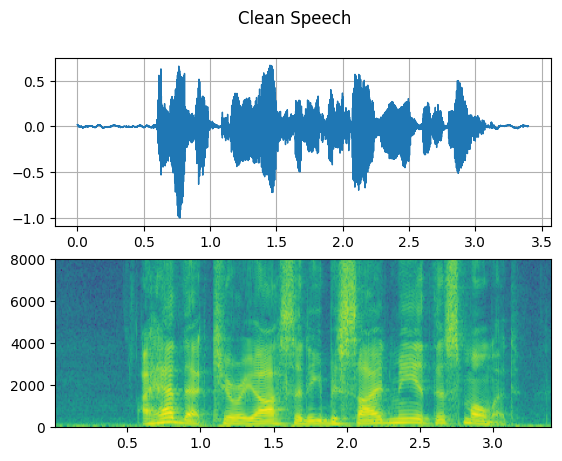

In [14]:
plot(WAVEFORM_SPEECH, "Clean Speech")

Visualize noise sample




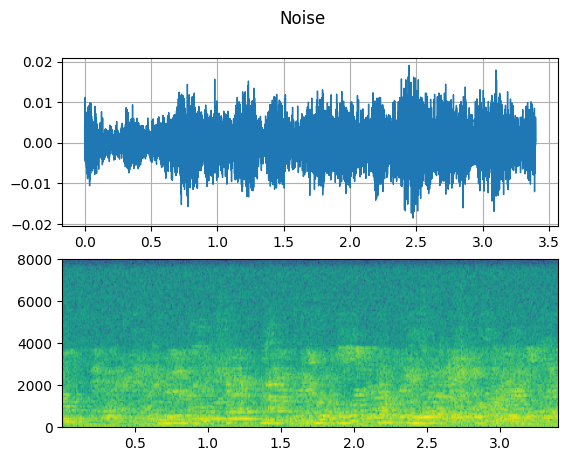

In [15]:
plot(WAVEFORM_NOISE, "Noise")

Visualize distorted speech with 20dB SNR




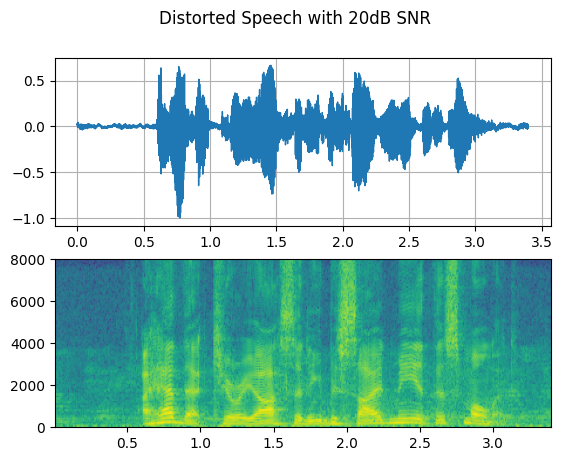

In [16]:
plot(WAVEFORM_DISTORTED[0:1], f"Distorted Speech with {snr_dbs[0]}dB SNR")

Visualize distorted speech with -5dB SNR




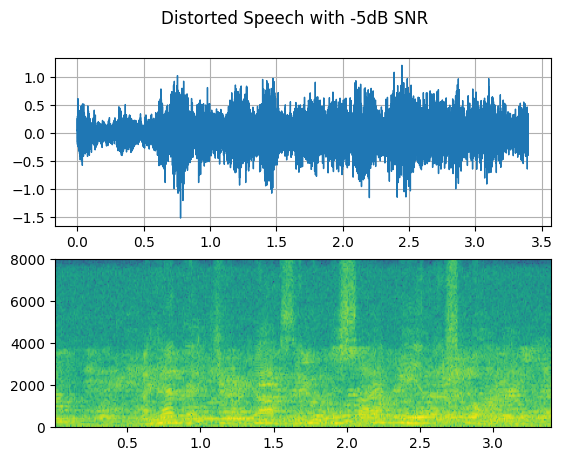

In [17]:
plot(WAVEFORM_DISTORTED[1:2], f"Distorted Speech with {snr_dbs[1]}dB SNR")

## 6. Predict Objective Metrics




Get the pre-trained ``SquimObjective``\ model.




In [18]:
objective_model = SQUIM_OBJECTIVE.get_model()

Downloading: "https://download.pytorch.org/torchaudio/models/squim_objective_dns2020.pth" to /root/.cache/torch/hub/checkpoints/squim_objective_dns2020.pth
100%|██████████| 28.2M/28.2M [00:00<00:00, 101MB/s] 


Compare model outputs with ground truths for distorted speech with 20dB
SNR




In [19]:
stoi_hyp, pesq_hyp, si_sdr_hyp = objective_model(WAVEFORM_DISTORTED[0:1, :])
print(f"Estimated metrics for distorted speech at {snr_dbs[0]}dB are\n")
print(f"STOI: {stoi_hyp[0]}")
print(f"PESQ: {pesq_hyp[0]}")
print(f"SI-SDR: {si_sdr_hyp[0]}\n")

pesq_ref = pesq(16000, WAVEFORM_SPEECH[0].numpy(), WAVEFORM_DISTORTED[0].numpy(), mode="wb")
stoi_ref = stoi(WAVEFORM_SPEECH[0].numpy(), WAVEFORM_DISTORTED[0].numpy(), 16000, extended=False)
si_sdr_ref = si_snr(WAVEFORM_DISTORTED[0:1], WAVEFORM_SPEECH)
print(f"Reference metrics for distorted speech at {snr_dbs[0]}dB are\n")
print(f"STOI: {stoi_ref}")
print(f"PESQ: {pesq_ref}")
print(f"SI-SDR: {si_sdr_ref}")

Estimated metrics for distorted speech at 20dB are

STOI: 0.9610356092453003
PESQ: 2.7801527976989746
SI-SDR: 20.692630767822266

Reference metrics for distorted speech at 20dB are

STOI: 0.9670831113894454
PESQ: 2.7961528301239014
SI-SDR: 19.998966217041016


Compare model outputs with ground truths for distorted speech with -5dB
SNR




In [20]:
stoi_hyp, pesq_hyp, si_sdr_hyp = objective_model(WAVEFORM_DISTORTED[1:2, :])
print(f"Estimated metrics for distorted speech at {snr_dbs[1]}dB are\n")
print(f"STOI: {stoi_hyp[0]}")
print(f"PESQ: {pesq_hyp[0]}")
print(f"SI-SDR: {si_sdr_hyp[0]}\n")

pesq_ref = pesq(16000, WAVEFORM_SPEECH[0].numpy(), WAVEFORM_DISTORTED[1].numpy(), mode="wb")
stoi_ref = stoi(WAVEFORM_SPEECH[0].numpy(), WAVEFORM_DISTORTED[1].numpy(), 16000, extended=False)
si_sdr_ref = si_snr(WAVEFORM_DISTORTED[1:2], WAVEFORM_SPEECH)
print(f"Reference metrics for distorted speech at {snr_dbs[1]}dB are\n")
print(f"STOI: {stoi_ref}")
print(f"PESQ: {pesq_ref}")
print(f"SI-SDR: {si_sdr_ref}")

Estimated metrics for distorted speech at -5dB are

STOI: 0.5743248462677002
PESQ: 1.1112866401672363
SI-SDR: -6.248741149902344

Reference metrics for distorted speech at -5dB are

STOI: 0.5848137931588825
PESQ: 1.0803768634796143
SI-SDR: -5.016279220581055


## 7. Predict Mean Opinion Scores (Subjective) Metric




Get the pre-trained ``SquimSubjective`` model.




In [21]:
subjective_model = SQUIM_SUBJECTIVE.get_model()

Downloading: "https://download.pytorch.org/torchaudio/models/squim_subjective_bvcc_daps.pth" to /root/.cache/torch/hub/checkpoints/squim_subjective_bvcc_daps.pth
100%|██████████| 360M/360M [00:01<00:00, 231MB/s]


Load a non-matching reference (NMR)




In [22]:
NMR_SPEECH = download_asset("tutorial-assets/ctc-decoding/1688-142285-0007.wav")

WAVEFORM_NMR, SAMPLE_RATE_NMR = torchaudio.load(NMR_SPEECH)
if SAMPLE_RATE_NMR != 16000:
    WAVEFORM_NMR = F.resample(WAVEFORM_NMR, SAMPLE_RATE_NMR, 16000)

Compute MOS metric for distorted speech with 20dB SNR




In [23]:
mos = subjective_model(WAVEFORM_DISTORTED[0:1, :], WAVEFORM_NMR)
print(f"Estimated MOS for distorted speech at {snr_dbs[0]}dB is MOS: {mos[0]}")

Estimated MOS for distorted speech at 20dB is MOS: 4.309269905090332


Compute MOS metric for distorted speech with -5dB SNR




In [24]:
mos = subjective_model(WAVEFORM_DISTORTED[1:2, :], WAVEFORM_NMR)
print(f"Estimated MOS for distorted speech at {snr_dbs[1]}dB is MOS: {mos[0]}")

Estimated MOS for distorted speech at -5dB is MOS: 3.2918035984039307


## 8. Comparison with ground truths and baselines

Visualizing the estimated metrics by the ``SquimObjective`` and
``SquimSubjective`` models can help users better understand how the
models can be applicable in real scenario. The graph below shows scatter
plots of three different systems: MOSA-Net [1], AMSA [2], and the
``SquimObjective`` model, where y axis represents the estimated STOI,
PESQ, and Si-SDR scores, and x axis represents the corresponding ground
truth.

<img src="https://download.pytorch.org/torchaudio/tutorial-assets/objective_plot.png" width="500px" align="center">

[1] Zezario, Ryandhimas E., Szu-Wei Fu, Fei Chen, Chiou-Shann Fuh,
Hsin-Min Wang, and Yu Tsao. “Deep learning-based non-intrusive
multi-objective speech assessment model with cross-domain features.”
IEEE/ACM Transactions on Audio, Speech, and Language Processing 31
(2022): 54-70.

[2] Dong, Xuan, and Donald S. Williamson. “An attention enhanced
multi-task model for objective speech assessment in real-world
environments.” In ICASSP 2020-2020 IEEE International Conference on
Acoustics, Speech and Signal Processing (ICASSP), pp. 911-915. IEEE,
2020.




The graph below shows scatter plot of the ``SquimSubjective`` model,
where y axis represents the estimated MOS metric score, and x axis
represents the corresponding ground truth.

<img src="https://download.pytorch.org/torchaudio/tutorial-assets/subjective_plot.png" width="500px" align="center">


